#ライブラリのインストール

In [1]:
!pip install -q transformers ipadic fugashi

     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 13.4 MB 30.5 MB/s 
     |████████████████████████████████| 568 kB 37.6 MB/s 
     |████████████████████████████████| 86 kB 2.1 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
     |████████████████████████████████| 6.6 MB 14.4 MB/s 


#ライブラリの読み込み

In [2]:
import re
import random
import pytz
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from transformers import BertJapaneseTokenizer, TFBertModel

In [27]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()

In [28]:
tf.config.experimental_connect_to_cluster(resolver)

In [29]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.118.25.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.118.25.138:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [30]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#定数

In [7]:
MODEL_NAME = "cl-tohoku/bert-base-japanese-whole-word-masking"
MAX_LENGTH = 128
BATCH_SIZE = 32
RANDOM_SEED = 265
TRAIN_SIZE = 0.8
EPOCHS = 20

In [8]:
TOKENIZER = BertJapaneseTokenizer.from_pretrained(
    MODEL_NAME
)

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

#livedorニュースコーパスの分類を学習させる

In [9]:
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar -zxf ldcc-20140209.tar.gz

--2022-06-21 11:00:00--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  1.88MB/s    in 4.5s    

2022-06-21 11:00:06 (1.88 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]



4行目以降に記事本文が入っている

In [10]:
!cat text/dokujo-tsushin/dokujo-tsushin-4778030.txt

http://news.livedoor.com/article/detail/4778030/
2010-05-22T14:30:00+0900
友人代表のスピーチ、独女はどうこなしている？
　もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？　さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。

　「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」

　さてそんなとき、独女はどう対応したらいいか？

　最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。

　「一晩で3人位の人が添削してくれましたよ。ちなみに自分以外にもそういう人はたくさんいて、その相談サイトには同じように添削をお願いする投稿がいっぱいありました」（由利さん）。ためしに教えてもらったそのサイトをみてみると、確かに「結婚式のスピーチの添削お願いします」という投稿が1000件を超えるくらいあった。めでたい結婚式の影でこんなネットコミュニティがあったとは知らなかった。

　しかし「事前にお願いされるスピーチなら準備ができるしまだいいですよ。一番嫌なのは何といってもサプライズスピーチ！」と語るのは昨年だけで10万以上お祝いにかかったというお祝い貧乏独女の薫さん（35歳）

　「私は基本的に人前で話すのが苦手なんですよ。だからいきなり指名されるとしどろもどろになって何もいえなくなる。そうすると自己嫌悪に陥って終わった後でもまったく楽しめなくなりますね」
　
　サプライズスピーチのメリットとしては、準備していない状態なので、フランクな本音をしゃべってもらえるという楽しさがあるようだ。しかしそれも上手に対応できる人なら

##データセットの準備

In [11]:
filepaths = tf.io.gfile.glob("./text/*/*-*.txt")
random.shuffle(filepaths)

In [12]:
labels = [filepath.split("/")[-2] for filepath in filepaths]

In [13]:
texts = ["".join(open(filepath).readlines()[3:]) for filepath in filepaths]

In [14]:
label_type = list(set(labels))
labels = [label_type.index(label) for label in labels]

In [15]:
encoding = TOKENIZER(
    texts,
    max_length=MAX_LENGTH, padding="max_length", 
    truncation=True,
    return_tensors="tf"
)

##訓練用とテスト用に分ける

In [16]:
counts = np.zeros((len(label_type), ), dtype=np.int32)
for label in labels:
    counts[label]+=1
print(label_type)
print(counts)

['smax', 'dokujo-tsushin', 'movie-enter', 'it-life-hack', 'livedoor-homme', 'sports-watch', 'peachy', 'topic-news', 'kaden-channel']
[870 870 870 870 511 900 842 770 864]


元のクラスの割合を崩さないように、訓練用とテスト用に分ける。

In [17]:
train_index = list()
test_index = list()

train_counts = np.zeros((len(label_type)), dtype=np.int32)
test_counts = np.zeros((len(label_type)), dtype=np.int32)
for i, label in enumerate(labels):
    if train_counts[label] < int(counts[label] * TRAIN_SIZE):
        train_index.append(i)
        train_counts[label]+=1
    else:
        test_index.append(i)
        test_counts[label]+=1

In [18]:
input_ids_train = np.zeros((train_counts.sum(), MAX_LENGTH), dtype=np.int32)
attention_mask_train = np.zeros((train_counts.sum(), MAX_LENGTH), dtype=np.int32)
token_type_ids_train = np.zeros((train_counts.sum(), MAX_LENGTH), dtype=np.int32)
labels_train = np.zeros((train_counts.sum()))

for i, j in enumerate(train_index):
    input_ids_train[i] = encoding["input_ids"][j]
    attention_mask_train[i] = encoding["attention_mask"][j]
    token_type_ids_train[i] = encoding["token_type_ids"][j]
    labels_train[i] = labels[j]

In [19]:
input_ids_test = np.zeros((test_counts.sum(), MAX_LENGTH), dtype=np.int32)
attention_mask_test = np.zeros((test_counts.sum(), MAX_LENGTH), dtype=np.int32)
token_type_ids_test = np.zeros((test_counts.sum(), MAX_LENGTH), dtype=np.int32)
labels_test = np.zeros((test_counts.sum()))

for i, j in enumerate(test_index):
    input_ids_test[i] = encoding["input_ids"][j]
    attention_mask_test[i] = encoding["attention_mask"][j]
    token_type_ids_test[i] = encoding["token_type_ids"][j]
    labels_test[i] = labels[j]

#文章分類モデルの構築

In [20]:
def build_model(bert_model_name, max_length, num_labels, bert_trainable=False):
    input_shape = (max_length, )

    input_ids = tf.keras.layers.Input(input_shape, dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(input_shape, dtype=tf.int32, name="attention_mask")
    token_type_ids = tf.keras.layers.Input(input_shape, dtype=tf.int32, name="token_type_ids")
    bert = TFBertModel.from_pretrained(
        bert_model_name, name="bert"
    )
    bert.layers[0].trainable = bert_trainable
    
    bert_output = bert.bert(
        [input_ids, attention_mask, token_type_ids]
    )

    pooler_output = bert_output.pooler_output
    pooler_output = tf.keras.layers.Dropout(0.2, name="dropout")(pooler_output)
    scores = tf.keras.layers.Dense(num_labels, activation="softmax", name="dense")(
        pooler_output
    )

    model = tf.keras.Model(
        inputs=[input_ids, attention_mask, token_type_ids], outputs=[scores],
        name="classification"
    )
    return model

In [142]:
with strategy.scope():
    classifier = build_model(
        bert_model_name=MODEL_NAME, 
        max_length=MAX_LENGTH, 
        num_labels=len(label_type),
        bert_trainable=False
    )

    classifier.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["acc"]
    )

Some layers from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#文章分類モデルの学習

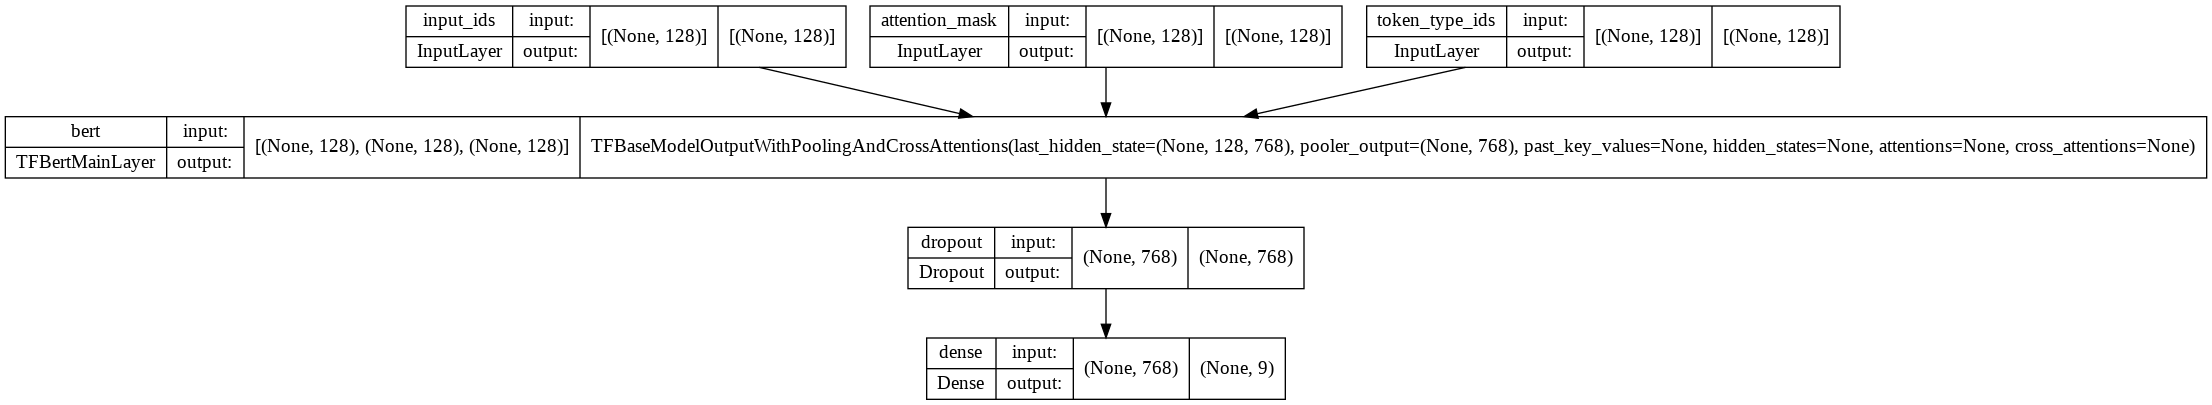

In [22]:
tf.keras.utils.plot_model(classifier, show_shapes=True, )

In [23]:
classifier.summary()

Model: "classification"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][

TPUで学習させると、GPUほど精度が上がらない。
[これのせいだろうか？](https://arxiv.org/abs/1711.00489)

TPUで回す時の[ModelCheckpointコールバック](https://stackoverflow.com/questions/70664617/how-to-add-model-checkpoint-as-callback-when-running-model-on-tpuv)について

In [150]:
def step_decay(epoch, lr):
    if epoch < 10: 
        return 0.001
    else:
        return 0.0001

checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')

history = classifier.fit(
    x=[input_ids_train, attention_mask_train, token_type_ids_train],
    y=labels_train,
    epochs=20,
    validation_data=(
        [input_ids_test, attention_mask_test, token_type_ids_test], labels_test
    ),
    validation_batch_size=BATCH_SIZE,
    callbacks = [
                 tf.keras.callbacks.LearningRateScheduler(step_decay),
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath="./ckpt",
                     save_weights_only=True, save_best_only=True,
                     monitor="val_loss", mode="min",
                     options=checkpoint_options
                 )
    ]
)

Epoch 1/20
185/185 [==============================] - 15s 82ms/step - loss: 0.8370 - acc: 0.7105 - val_loss: 0.7424 - val_acc: 0.7492 - lr: 0.0010
Epoch 2/20
185/185 [==============================] - 15s 79ms/step - loss: 0.8379 - acc: 0.7077 - val_loss: 0.7173 - val_acc: 0.7607 - lr: 0.0010
Epoch 3/20
185/185 [==============================] - 11s 62ms/step - loss: 0.8324 - acc: 0.7101 - val_loss: 0.7522 - val_acc: 0.7444 - lr: 0.0010
Epoch 4/20
185/185 [==============================] - 11s 59ms/step - loss: 0.8175 - acc: 0.7247 - val_loss: 0.7516 - val_acc: 0.7410 - lr: 0.0010
Epoch 5/20
185/185 [==============================] - 9s 51ms/step - loss: 0.8252 - acc: 0.7220 - val_loss: 0.7271 - val_acc: 0.7485 - lr: 0.0010
Epoch 6/20
185/185 [==============================] - 9s 50ms/step - loss: 0.8374 - acc: 0.7050 - val_loss: 0.7301 - val_acc: 0.7553 - lr: 0.0010
Epoch 7/20
185/185 [==============================] - 16s 86ms/step - loss: 0.8174 - acc: 0.7132 - val_loss: 0.7005 - va

#学習結果の確認

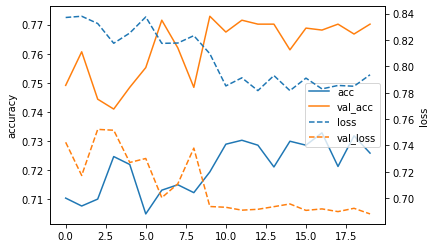

In [151]:
fig, ax = plt.subplots(nrows=1, ncols=1)

line1 = ax.plot(history.epoch, history.history["acc"], label="acc")
line2 = ax.plot(history.epoch, history.history["val_acc"], label="val_acc")
ax.set_ylabel("accuracy")
ay=ax.twinx()
line3 = ay.plot(history.epoch, history.history["loss"], label="loss", linestyle="--")
line4 = ay.plot(history.epoch, history.history["val_loss"], label="val_loss", linestyle="--")
ay.set_ylabel("loss")

lines = line1 + line2 + line3 + line4
line_labels = [l.get_label() for l in lines]
ax.legend(lines, line_labels, loc="center right")
plt.show()

#モデルの予測結果

In [152]:
print(classifier.evaluate([input_ids_test, attention_mask_test, token_type_ids_test], labels_test))

47/47 [==============================] - 2s 32ms/step - loss: 0.6881 - acc: 0.7702
[0.6881418824195862, 0.7701695561408997]


In [153]:
index = np.random.randint(0, len(input_ids_test), 5)
input_ids_sample = input_ids_test.take(index, axis=0)
attention_mask_sample = attention_mask_test.take(index, axis=0)
token_type_ids_sample = token_type_ids_test.take(index, axis=0)

pred = classifier.predict(
    [input_ids_sample, attention_mask_sample, token_type_ids_sample]
)

In [154]:
for i in range(5):
    print(TOKENIZER.decode(input_ids_sample[i]).replace(" ", ""))
    max_index = np.argmax(pred[i])
    print(f"prediction : {max_index:d} ({pred[i][max_index]*100:.2f}%)")
    print(f"answer : {int(labels_test[index[i]])} (="+label_type[int(labels_test[index[i]])]+")\n")

[CLS]ロンドン五輪・柔道男子60kg級で銀メダルを獲得した平岡拓晃が、テレビ朝日の五輪特別番組に出演した。「メダルは金ではなかったんですが、4年間頑張ってきた色なのかなと思います」と切り出した平岡。準々決勝では、フランスのミルを相手に大接戦を繰り広げたが、「ポイントを取られていたので、前に出るしかないと思ってですね、抱きついてでもポイントを取ろうと思った。オリンピック前の練習でポイントを取られた時[SEP]
prediction : 5 (96.93%)
answer : 5 (=sports-watch)

[CLS]「なるほど、そういうことか!Googleロゴが折り紙である理由」で紹介したように、Googleはたまにトップページのロゴを変える。今、Googleにアクセスすると、トップページのGoogleロゴが変わっているのに気づくだろう。Googleロゴは、可愛らしいに見える。クリックすると、「春分の日」という言葉が検索される。今日(3月20日)は、文字通りに春分が起こる日だからだ。春分の日は、日本の国民の祝日のひとつだ。昼と夜の長さが[SEP]
prediction : 3 (53.71%)
answer : 3 (=it-life-hack)

[CLS]約60億キロの飛行の末、地球へと帰還した小惑星探査機「はやぶさ」の偉業を基につくられた映画『おかえり、はやぶさ』。父への葛藤をかかえたJAXAエンジニア助手・大橋建人を藤原竜也が、まっすぐに宇宙への憧れを追い求める理学博士・野村奈緒子を杏が好演する。二人は、本作にどのように向かい合ったのか。前田旺志郎ら共演者の印象なども含め聞いてみた。——お二[SEP]
prediction : 2 (92.86%)
answer : 2 (=movie-enter)

[CLS]バレンタインデーまで一週間をきり、街角全体がハッピーオーラに包まれる今日この頃。チョコレートの準備は終わりましたか?大切な彼には、チョコレートだけではなくプレゼントも添えたいのが乙女ゴコロ。実際に身につけたり、お部屋に置ける小物なら受け取る側もHAPPYなはず。大人の男性をターゲットにネクストスタンダードスタイルを発信している、スペシャリティストア「ESTNATION」には大好きな気持ちを伝えたい、とっておきの小物が勢ぞろい[SEP]
pre

In [155]:
classifier.save("classifier.h5")

In [156]:
loaded_model = tf.keras.models.load_model("classifier.h5")

In [157]:
loaded_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["acc"]
)

In [158]:
pred = loaded_model.predict(
    [input_ids_sample, attention_mask_sample, token_type_ids_sample]
)
for i in range(5):
    print(TOKENIZER.decode(input_ids_sample[i]).replace(" ", ""))
    max_index = np.argmax(pred[i])
    print(f"prediction : {max_index:d} ({pred[i][max_index]*100:.2f}%)")
    print(f"answer : {int(labels_test[index[i]])} (="+label_type[int(labels_test[index[i]])]+")\n")

[CLS]ロンドン五輪・柔道男子60kg級で銀メダルを獲得した平岡拓晃が、テレビ朝日の五輪特別番組に出演した。「メダルは金ではなかったんですが、4年間頑張ってきた色なのかなと思います」と切り出した平岡。準々決勝では、フランスのミルを相手に大接戦を繰り広げたが、「ポイントを取られていたので、前に出るしかないと思ってですね、抱きついてでもポイントを取ろうと思った。オリンピック前の練習でポイントを取られた時[SEP]
prediction : 5 (96.96%)
answer : 5 (=sports-watch)

[CLS]「なるほど、そういうことか!Googleロゴが折り紙である理由」で紹介したように、Googleはたまにトップページのロゴを変える。今、Googleにアクセスすると、トップページのGoogleロゴが変わっているのに気づくだろう。Googleロゴは、可愛らしいに見える。クリックすると、「春分の日」という言葉が検索される。今日(3月20日)は、文字通りに春分が起こる日だからだ。春分の日は、日本の国民の祝日のひとつだ。昼と夜の長さが[SEP]
prediction : 3 (53.85%)
answer : 3 (=it-life-hack)

[CLS]約60億キロの飛行の末、地球へと帰還した小惑星探査機「はやぶさ」の偉業を基につくられた映画『おかえり、はやぶさ』。父への葛藤をかかえたJAXAエンジニア助手・大橋建人を藤原竜也が、まっすぐに宇宙への憧れを追い求める理学博士・野村奈緒子を杏が好演する。二人は、本作にどのように向かい合ったのか。前田旺志郎ら共演者の印象なども含め聞いてみた。——お二[SEP]
prediction : 2 (92.80%)
answer : 2 (=movie-enter)

[CLS]バレンタインデーまで一週間をきり、街角全体がハッピーオーラに包まれる今日この頃。チョコレートの準備は終わりましたか?大切な彼には、チョコレートだけではなくプレゼントも添えたいのが乙女ゴコロ。実際に身につけたり、お部屋に置ける小物なら受け取る側もHAPPYなはず。大人の男性をターゲットにネクストスタンダードスタイルを発信している、スペシャリティストア「ESTNATION」には大好きな気持ちを伝えたい、とっておきの小物が勢ぞろい[SEP]
pre

In [159]:
loaded_model = build_model(
    bert_model_name=MODEL_NAME, 
    max_length=MAX_LENGTH, 
    num_labels=len(label_type),
    bert_trainable=False
)

loaded_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["acc"]
)

Some layers from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [161]:
loaded_model.load_weights("./ckpt")

InvalidArgumentError: ignored